In [556]:
import numpy as np 
import h5py 
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas as pd

from os import listdir
from os.path import isfile, join
import os 

In [692]:
def show_map(FILE_NAME, DATAFIELD_NAME, loc, Colormap = "viridis", missing_value=None, minv=None, maxv=None, zoom=1):
# Open file.

    fig = plt.figure(figsize=[15,15])
    with h5py.File(FILE_NAME, mode='r') as f:
        # List available datasets.
        print(f.keys())

        # Read dataset.
        dset = f[DATAFIELD_NAME]
        data = dset[:]

        DU_1 = 2.6867*10**16
        data = data/DU_1
        units = "DU"
        
        if minv is not None:
            data[data<minv] =np.NaN
        
        if maxv is not None:
            data[data>maxv] =np.NaN
            
        # Get attributes needed for the plot.
        # String attributes actually come in as the bytes type and should
        # be decoded to UTF-8 (python3).
        title = dset.attrs['Title'].decode()
        units = dset.attrs['Units'].decode()
        
       
        
        longitude = np.arange(0., 1440.0) * 0.25 - 180 + 0.125
        latitude = np.arange(0., 720.0) * 0.25 - 90 + 0.125

        #m = Basemap(projection='cyl', resolution='l', llcrnrlat=-90, urcrnrlat = 90, llcrnrlon=-180, urcrnrlon = 180)
        
        llcrnrlat = loc['lat'] -zoom
        urcrnrlat = loc['lat'] +zoom
        llcrnrlon = loc['long'] -zoom 
        urcrnrlon = loc['long'] +zoom 
        
        m = Basemap(width=1200000,height=900000,
                    projection='cyl', 
                    resolution='l', 
                    llcrnrlat=llcrnrlat, 
                    urcrnrlat = urcrnrlat, 
                    llcrnrlon=llcrnrlon, 
                    urcrnrlon = urcrnrlon)
        
        
        m.drawcoastlines(linewidth=1)
        m.drawparallels(np.arange(-90., 120., 3.), labels=[1, 0, 0, 0])
        m.drawmeridians(np.arange(-180., 181., 6.), labels=[0, 0, 0, 1])
        #x, y = m(longitude, latitude,)
        
      
            
        aaa = m.pcolormesh(longitude, latitude, data, latlon=True, cmap=Colormap, vmin=minv, vmax=maxv)
        cb = m.colorbar()
        
        cb.set_label(units)
        
# this get all file froma a directory 
def get_files(mypath):
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f)) and not f.startswith(".")]
    return sorted(onlyfiles)

def xy(angle_lat, angle_lon):
    y = (-1)* 720 * angle_lon/ (-180)
    x = (-1) * 1440 * angle_lat/ (-360)
    
    if y >720: y=720
    if x >1440: x=1440

    return np.int16(np.round(x)), np.int16(np.round(y))


In [693]:
datadesc_OMNO2 = {"shortname":"OMNO2",
                    "path":"./data/OMNO2d.003/2020/", 
                    "datafield":"/HDFEOS/GRIDS/ColumnAmountNO2/Data Fields"}

signal_ColumnAmountNO2TropCloudScreened = {"name":"ColumnAmountNO2TropCloudScreened",
                                           "missing_value":-1.2676506e+30}

location_range_all = {"llcrnrlat":-90, "urcrnrlat" : 90, "llcrnrlon":-180, "urcrnrlon" : 180}
location_range_wuhan = {"llcrnrlat":33, "urcrnrlat" : 50, "llcrnrlon":112, "urcrnrlon":122}

location_range_italy = {"name":"italy", lat":41.8, "long" :12.8, "zoom":5}
location_range_milan = {"name":"milan", "lat":45.5, "long" :9.1, "zoom":0.5}
location_range_boston = {"name":"boston", "lat":42.3, "long" :-71, "zoom":5}
location_range_beijin = {"name":"beijin", "lat":39, "long" :116, "zoom":5}
location_range_manaus = {"name":"manaus", "lat":-3, "long" :-60, "zoom":5}
location_range_sanpaolo= {"name":"sanpaolo", "lat":-24, "long" :-47, "zoom":5}
location_range_sydney= {"name":"sydney", "lat":-34, "long" :151, "zoom":5}
                        

In [694]:
path = datadesc_OMNO2['path']
allfiles = get_files(path)
file_name = os.path.join(path, allfiles[2])
datafield = datadesc_OMNO2['datafield']
datafield_path = datafield+"/ColumnAmountNO2TropCloudScreened"

data_h5 = h5py.File(file_name,"r")
print(data_h5[datafield].keys())
data = data_h5[datafield_path]
data=np.array(data)

<KeysViewHDF5 ['ColumnAmountNO2', 'ColumnAmountNO2CloudScreened', 'ColumnAmountNO2Trop', 'ColumnAmountNO2TropCloudScreened', 'Weight']>


<KeysViewHDF5 ['HDFEOS', 'HDFEOS INFORMATION']>

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


<Figure size 1440x720 with 0 Axes>

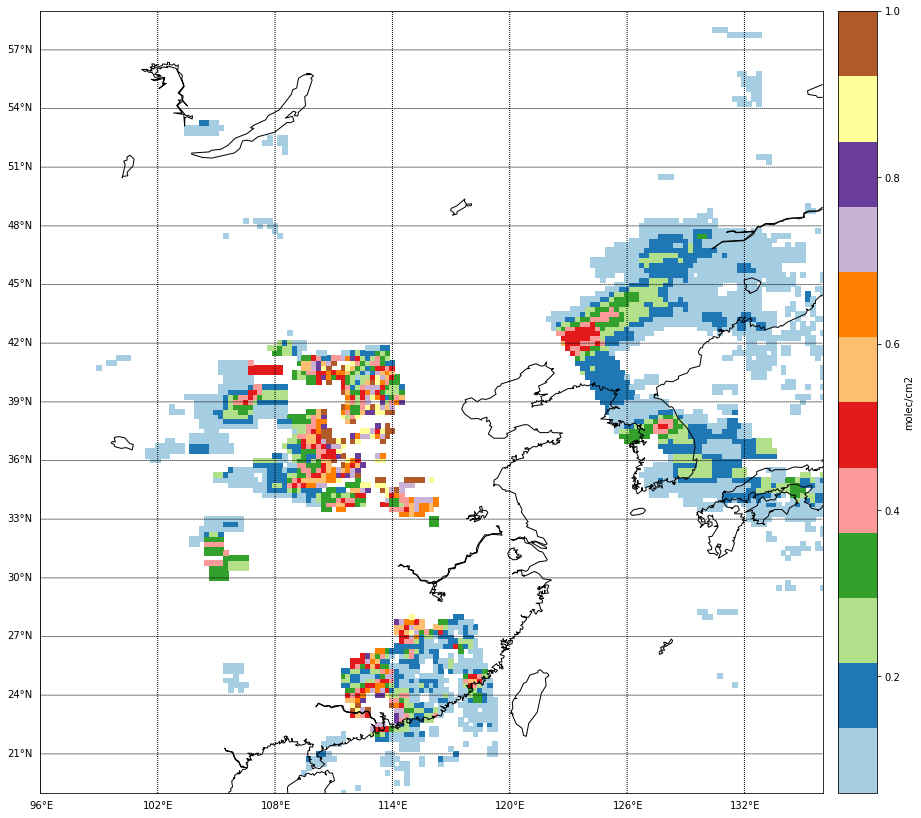

In [696]:
plt.figure(figsize=[20,10])

show_map(file_name, 
         datafield_path, 
         location_range_beijin, 
         Colormap="Paired", 
         missing_value=signal_ColumnAmountNO2TropCloudScreened["missing_value"],
         minv =0.06,
         maxv=1,
         zoom=20)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater


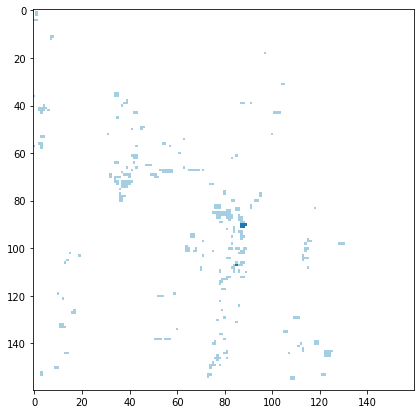

(0.05859821,
 0.07937425,
 0.10015029,
 0.006572498008608818,
 0.07121453434228897,
 0.16082411631941795)

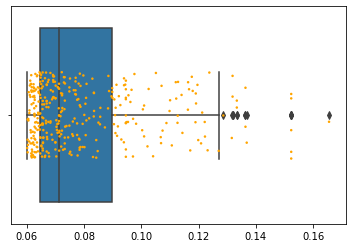

In [700]:
#location_range_beijin = {"llcrnrlat":33, "urcrnrlat" : 54, "llcrnrlon":112, "urcrnrlon":121}
import seaborn as sns




def get_location_stats(location, data, zoom = 1, 
                       units="DU" , minv=None, maxv=None, 
                       show_map=False, show_stats=False,
                       figsize = [7,7]):
    '''
    location = info about location, ex. format = {"lat":39, "long" :116, "zoom":5}
    data = 2d array (lat x long) of satellite signals
    units = DU of molcm2, 1 DU = 2.6867*10**16 mol/cm2
    
    '''
    
    
    longitude = np.arange(0., 1440.0) * 0.25 - 180 + 0.125
    latitude = np.arange(0., 720.0) * 0.25 - 90 + 0.125

    X = np.argwhere((latitude>location["lat"]-zoom) & (latitude<=location["lat"]+zoom)).flatten()
    Y = np.argwhere((longitude>location["long"]-zoom) & (longitude<=location["long"]+zoom)).flatten()
    data_filtered = data[X,:]
    data_filtered = data_filtered[:,Y]
    
    if units =="DU":
        DU = 2.6867*10**16
        data_filtered = data_filtered/DU 
        
    if minv is not None:
        data_filtered[data_filtered<minv]=np.NaN
    if maxv is not None:
        data_filtered[data_filtered>maxv]=np.NaN

    if show_map ==True:
        plt.figure(figsize=figsize)
        plt.imshow(data_filtered, cmap="Paired", vmin=minv, vmax=maxv)
        plt.show()
    if show_stats == True:
        d = [ i for i in data_filtered.flatten()  if i >0 ]
        bp = sns.boxplot(d)
        sns.stripplot(d, color="orange", jitter=0.2, size=2.5,)

        #plt.show()
        
    Q1 = np.nanpercentile(data_filtered, 25)
    MD = np.nanpercentile(data_filtered, 50)
    Q2 = np.nanpercentile(data_filtered, 75)
    SD = np.nanstd(data_filtered)
    MN = np.nanmean(data_filtered)
    return MN-SD, MN, MN+SD, MD-Q1, MD,  MD+Q2


get_location_stats(location_range_sanpaolo,
                  data,
                  zoom=20,
                  minv=0.06,
                  maxv=1,
                  show_map=True, 
                  show_stats=True)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater


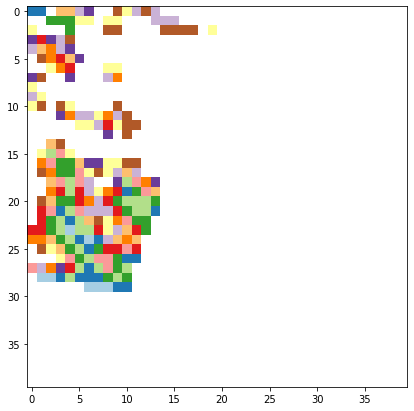

(0.30297652,
 0.5714413,
 0.8399061,
 0.2541135996580124,
 0.5794453024864197,
 1.413295865058899)

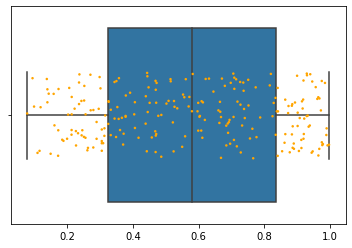

In [690]:
get_location_stats(location_range_beijin,
                  data,
                  zoom =5,
                  minv=0.06,
                  maxv=1,
                  show_map=True, 
                  show_stats=True)

In [730]:
data[data<0]=np.NaN
num_nan = data[np.isnan(data)].shape[0]
n = data.flatten().shape[0]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


In [732]:
data[np.isnan(data)].shape

(709212,)

In [724]:
d = data.flatten()
d[~np.isnan(d)].shape

(327588,)

In [711]:
d[d==np.NaN]

array([], dtype=float32)

In [720]:
for i in d:
    #print(i)
    if i == np.NaN:
        print("w")